---
title: "Supervised Learning"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 

In [139]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from fancyimpute import IterativeImputer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
from sklearn.inspection import permutation_importance
from textblob import TextBlob
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud

In [57]:
# Load the CSV file
file_path = '../../data/processed-data/merged_data.csv'
data = pd.read_csv(file_path)

## Data Preprocessing

We will use the IterativeImputer method to perform multiple imputations on the financial variables. This will estimate missing values based on other features in the dataset.

In [58]:
# Define the financial columns that require imputation
Asset_Profitability_columns = [
    'Assets (k)', 'RevenueFromContractWithCustomerExcludingAssessedTax (k)', 
    'OperatingIncomeLoss (k)', 'ComprehensiveIncomeNetOfTax (k)'
]

# Perform multiple imputation for missing values in the financial columns
imputer = IterativeImputer()
data[Asset_Profitability_columns] = imputer.fit_transform(data[Asset_Profitability_columns])

We will apply Z-score normalization to the financial columns and Total. This transformation scales the data such that the mean is 0 and the standard deviation is 1. After Z-score normalization, we apply Min-Max normalization to scale the data within the range [0, 1].

In [59]:
# Define the columns to normalize (financial columns + Total)
columns_to_standardize = Asset_Profitability_columns + ['Total']

# Apply Z-score normalization
scaler = StandardScaler()
data[columns_to_standardize] = scaler.fit_transform(data[columns_to_standardize])

# Apply Min-Max normalization to the same columns
min_max_scaler = MinMaxScaler()
data[columns_to_standardize] = min_max_scaler.fit_transform(data[columns_to_standardize])

We will convert the values of some columns. If the value is 'Met', we will change it to 1, and if it is 'Unmet', we will change it to 0. 

In [60]:
data['GR-B07.EA- Assessment'] = data['GR-B07.EA- Assessment'].map({'Met': 1, 'Unmet': 0})

We create the data frame for SVM Model.

In [272]:
df_svm = data[['Assets (k)', 'RevenueFromContractWithCustomerExcludingAssessedTax (k)', 
               'OperatingIncomeLoss (k)', 'ComprehensiveIncomeNetOfTax (k)', 'Total', 
               'GR-B07.EA- Assessment']]
print(df_svm.head())

   Assets (k)  RevenueFromContractWithCustomerExcludingAssessedTax (k)  \
0    0.014250                                           0.008925         
1    0.110727                                           0.033700         
2    0.129706                                           0.075024         
3    0.050717                                           0.016509         
4    0.018646                                           0.016485         

   OperatingIncomeLoss (k)  ComprehensiveIncomeNetOfTax (k)     Total  \
0                 0.044333                         0.024057  0.400749   
1                 0.030927                         0.011276  0.430712   
2                 0.081382                         0.061669  0.123596   
3                 0.043063                         0.022815  0.408240   
4                 0.040476                         0.025715  0.314607   

   GR-B07.EA- Assessment  
0                      1  
1                      1  
2                      0  
3       

We normalized some other financial columns.

In [61]:
Liquidity_Market_columns = [
    'EarningsPerShareBasic', 'EntityPublicFloat (k)', 'AllocatedShareBasedCompensationExpense (k)',
    'CashAndCashEquivalentsAtCarryingValue (k)', 'AccountsReceivableNetCurrent (k)']

# Perform multiple imputation for missing values in the financial columns
imputer = IterativeImputer()
data[Liquidity_Market_columns] = imputer.fit_transform(data[Liquidity_Market_columns])

In [62]:
# Define the columns to normalize (financial columns + Total)
columns_to_standardize = Liquidity_Market_columns

# Apply Z-score normalization
scaler = StandardScaler()
data[columns_to_standardize] = scaler.fit_transform(data[columns_to_standardize])

# Apply Min-Max normalization to the same columns
min_max_scaler = MinMaxScaler()
data[columns_to_standardize] = min_max_scaler.fit_transform(data[columns_to_standardize])

We choose to convert CEO Gender to binary (1 for Male, 0 for Female)

In [63]:
# Convert CEO Gender to binary (1 for Male, 0 for Female)
data['CEO Gender'] = data['CEO Gender'].map({'Male': 1, 'Female': 0})

In [64]:
data['GL-B01.EA-Assessment'] = data['GL-B01.EA-Assessment'].map({'Met': 1, 'Unmet': 0})
data['EE-B06.EB-Assessment'] = data['EE-B06.EB-Assessment'].map({'Met': 1, 'Unmet': 0})

We create the data frame for logistic regression model.

In [ ]:
df_lr = data[['Assets (k)', 'EntityPublicFloat (k)', 'CEO Gender',
              'AccountsReceivableNetCurrent (k)',
              'GL-B01.EA-Assessment', 'EE-B06.EB-Assessment']]
print(df_lr.head())

   Assets (k)  EntityPublicFloat (k)  CEO Gender  \
0    0.014250               0.002023           1   
1    0.110727               0.002541           1   
2    0.129706               0.013596           1   
3    0.050717               0.003250           1   
4    0.018646               0.000391           1   

   AccountsReceivableNetCurrent (k)  GL-B01.EA-Assessment  \
0                          0.017058                     0   
1                          0.057146                     0   
2                          0.084879                     0   
3                          0.056278                     0   
4                          0.034306                     1   

   EE-B06.EB-Assessment  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  


We applied sentiment analysis using TextBlob to the textual data in the 'SE-A06.EA-Evidence', 'GPG-C01.EA-Evidence_Sentiment' and 'EE-B06.EB-Evidence' columns to calculate the sentiment polarity score for each row.

In [65]:
# Define a function to calculate sentiment score for a given text
def get_sentiment_score(text):
    if pd.isna(text):
        return 0
    return TextBlob(str(text)).sentiment.polarity  # Return the sentiment polarity score for non-missing text

# Perform sentiment analysis on 'SE-A06.EA-Evidence' and 'EE-B06.EB-Evidence' columns
data['SE-A06.EA-Evidence_Sentiment'] = data['SE-A06.EA-Evidence'].apply(get_sentiment_score)
data['GPG-C01.EA-Evidence_Sentiment'] = data['GPG-C01.EA-Evidence'].apply(get_sentiment_score)
data['EE-B06.EB-Evidence_Sentiment'] = data['EE-B06.EB-Evidence'].apply(get_sentiment_score)

# View the results of sentiment analysis
print(data[['SE-A06.EA-Evidence_Sentiment', 'GPG-C01.EA-Evidence_Sentiment','EE-B06.EB-Evidence_Sentiment']].head())

   SE-A06.EA-Evidence_Sentiment  GPG-C01.EA-Evidence_Sentiment  \
0                         0.200                       0.000000   
1                         0.135                       0.000000   
2                         0.000                      -0.122917   
3                        -0.125                       0.200000   
4                         0.000                       0.000000   

   EE-B06.EB-Evidence_Sentiment  
0                      0.200000  
1                      0.000000  
2                      0.210204  
3                      0.000000  
4                      0.000000  


We create the data frame for Gradient Boosting Regression.

In [40]:
df_br = data[['ComprehensiveIncomeNetOfTax (k)', 'EntityPublicFloat (k)', 
              'GPG-C01.EA-Evidence_Sentiment', 'GR-B07.EA- Assessment', 
              'GL-B01.EA-Assessment','Total']]
print(df_br.head())

   ComprehensiveIncomeNetOfTax (k)  EntityPublicFloat (k)  \
0                         0.024057               0.002023   
1                         0.011276               0.002541   
2                         0.061669               0.013596   
3                         0.022815               0.003250   
4                         0.025715               0.000391   

   GPG-C01.EA-Evidence_Sentiment  GR-B07.EA- Assessment  GL-B01.EA-Assessment  \
0                       0.000000                      1                     0   
1                       0.000000                      1                     0   
2                      -0.122917                      0                     0   
3                       0.200000                      0                     0   
4                       0.000000                      0                     1   

      Total  
0  0.400749  
1  0.430712  
2  0.123596  
3  0.408240  
4  0.314607  


We choose to convert 'HSW-D01.EC-Assessment' to multiclasses (1 for Met, 0 for Unmet, 2 for Partially Met)

In [66]:
data['HSW-D01.EC-Assessment'] = data['HSW-D01.EC-Assessment'].map({'Met': 1, 'Unmet': 0, 'Partially Met': 2})

Some company do not have evidence, so we created a new column 'HSW-D01.EC-evidence_filled', where missing evidence values are filled with the explanation text.

In [72]:
# Define a function to fill NaN values with the corresponding explanation
def fill_na_with_explanation(row, explanation):
    if pd.isna(row):
        return explanation  # Use the explanation from the 'explanation' column
    return row

# Apply the function to the 'evidence' column and create a new column 'evidence_filled'
data['HSW-D01.EC-evidence_filled'] = data.apply(lambda row: fill_na_with_explanation(row['HSW-D01.EC-Evidence'], row['HSW-D01.EC-Explanation']), axis=1)

We created the data frame for random forest.

In [75]:
df_rf = data[['HSW-D01.EC-Assessment', 'HSW-D01.EC-evidence_filled']]
print(df_rf.head())

   HSW-D01.EC-Assessment                         HSW-D01.EC-evidence_filled
0                      0  evidence found regarding whether company provi...
1                      0  employees families access digital physical the...
2                      0  assessment evaluated publicly available inform...
3                      2  fertility support winfertilitys fertility supp...
4                      0  evidence found regarding whether company provi...


## Binary Classification

### Support Vector Machine (SVM)

#### Feature Selection For SVM

**Features**:

Dependent Variable:

GR-B07.EA- Assessment: Whether the company procures from women-owned businesses. This target variable is important as it reflects a company’s commitment to diversity and inclusion within its supply chain. Procurement from women-owned businesses is a clear indicator of a company’s social responsibility practices, and it aligns with gender equity goals. The target variable helps answer the key question of whether financial and operational factors influence a company’s willingness and ability to support women-owned businesses.

Independent Variable:

Assets (k): This represents the total assets of the company, typically in thousands of units (e.g., thousands of dollars). Assets provide a measure of the company’s overall size and financial stability, reflecting the resources available for operation, expansion, or investments.

RevenueFromContractWithCustomerExcludingAssessedTax (k): This is the revenue generated from contracts with customers, excluding taxes. It helps gauge the company’s revenue streams, focusing on its core business activities. This variable is important as it provides insights into the company's revenue base without being influenced by tax policies.

OperatingIncomeLoss (k): This metric indicates the operating income or loss of the company, in thousands. It reflects the company's ability to generate profit from its regular business operations, excluding factors like interest or taxes. It is a key indicator of operational efficiency and profitability.

ComprehensiveIncomeNetOfTax (k): This represents the total comprehensive income, net of taxes, of the company. Comprehensive income includes all revenues, gains, and losses, and is a broader measure than net income. It reflects the overall financial health of the company, considering both operational and non-operational factors.

Total: Reflects the company’s overall gender equality score or assessment. 

**Objective**:

The objective of the model is to predict whether a company procures from women-owned businesses based on various financial and operational factors. The target variable, GR-B07.EA-Assessment, is a binary variable that indicates whether the company engages in procurement from women-owned businesses, reflecting its commitment to diversity and inclusion in the supply chain. This variable is crucial as it helps assess the company’s alignment with gender equity goals and broader social responsibility practices.

By using Support Vector Machine (SVM) for classification, we aim to understand how the selected independent variables—such as company assets, revenue, operating income, comprehensive income, and gender equality scores—affect the company's willingness and ability to support women-owned businesses. The SVM model can identify non-linear relationships between these financial indicators and the procurement practices, offering insights into how financial stability, profitability, and gender equality initiatives influence business decisions.

#### Model Selection

##### Model Rationale:

The Support Vector Machine (SVM) is selected for this classification task because it effectively handles both linear and non-linear classification problems, especially with high-dimensional data. SVM is well-suited for predicting whether a company procures from women-owned businesses, using financial and gender equality features, as it maximizes the margin between classes for better generalization. Key advantages of SVM include its ability to handle high-dimensional spaces, suitability for binary classification, capability to capture non-linear relationships through kernel functions, and regularization via the CC parameter, which prevents overfitting by balancing margin maximization and error minimization.

##### Overview of Algorithms:

The Support Vector Machine (SVM) algorithm is based on finding a hyperplane that best separates different classes by maximizing the margin between them. If the data is not linearly separable, SVM uses kernel functions to transform the data into a higher-dimensional space, where a linear hyperplane can be found. The decision rule is based on the equation of the hyperplane:

$$ f(x) = \langle w, x \rangle + b $$

where w is the weight vector, x is the input feature vector, and b is the bias term.

#### Training and Testing Strategy For SVM

First, we split the data into training set and testing set. We split the dataset into 80% for training and 20% for testing.

In [ ]:
# Assuming 'df_svm' contains the relevant features and 'CEO_Gender' is the target variable
X = df_svm.drop(columns=['GR-B07.EA- Assessment'])
y = df_svm['GR-B07.EA- Assessment']

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5000)

We will use Stratified K-Fold Cross-Validation to ensure balanced distributions of the target variable in each fold.

In [245]:
# Define SVM model
model = SVC()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1, 10],  # Range of values for C (regularization parameter)
    'kernel': ['linear', 'rbf', 'poly'],  # Selection of kernel types
    'gamma': ['scale', 'auto'],  # Gamma parameter options
    'class_weight': [None, 'balanced']  # Whether to use class weights
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output the best parameters
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


#### Model Evaluation Metrics For SVM

In [ ]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate binary classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_model.decision_function(X_test))

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

Accuracy: 0.73
Precision: 0.79
Recall: 0.68
F1 Score: 0.73
ROC-AUC: 0.74


#### Results For SVM

##### Model Performance Summary

The model's performance demonstrates a reasonable ability to predict whether a company procures from women-owned businesses based on financial data and the company's gender equality score. The accuracy is 0.73, indicating that the model correctly classifies 73% of the instances. The precision of 0.79 shows that when the model predicts the positive class (i.e., the company procures from women-owned businesses), it is correct 79% of the time. However, the recall of 0.68 suggests that the model misses about 32% of the true positive cases. The F1 score of 0.73 balances precision and recall, while the ROC-AUC of 0.74 indicates a moderate level of model performance in distinguishing between the two classes.

##### Visualization

###### ROC Curve

The ROC curve shows the model's ability to distinguish between companies that procure from women-owned businesses and those that do not. The curve is plotted with the false positive rate on the x-axis and the true positive rate on the y-axis. 

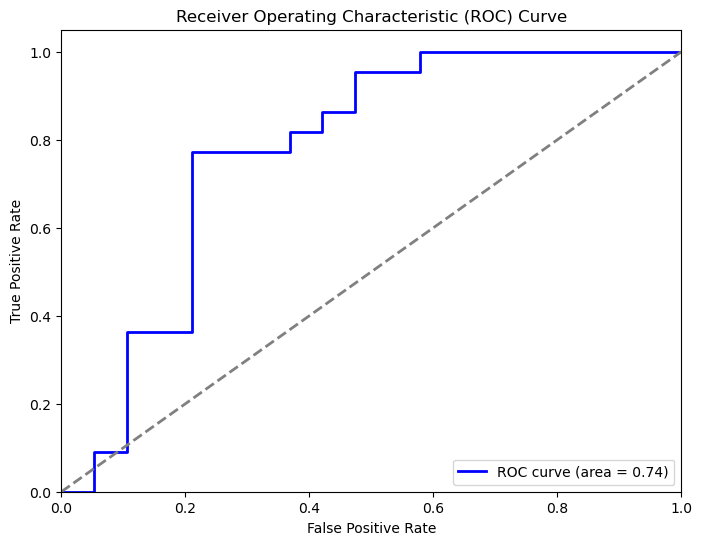

In [77]:
# Visualize the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**Visual Observations**:

The model performs decently, with an AUC of 0.74, indicating it has a 74% chance of correctly distinguishing between the two classes. 

**Key Insights**:

The model performs better than random guessing (as the curve is above the diagonal), there is still room for improvement in its ability to make accurate predictions.

###### Feature Importance Plot

The purpose of plotting the feature importance is to evaluate which features have the most influence on the model’s predictions.

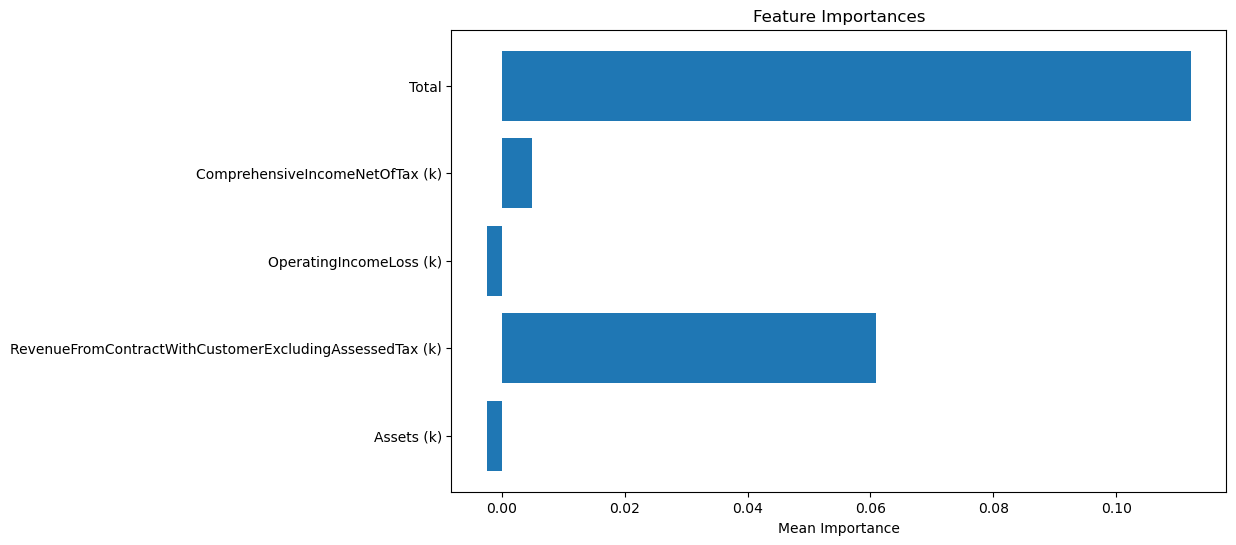

In [78]:
# Feature importance using permutation importance (for SVM, if not linear)
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
importances = result.importances_mean
features = X.columns

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(features)), importances, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Mean Importance')
plt.show()

**Visual Observations**:

The feature importance plot shows that the "Total" feature, likely representing the company's overall gender equality score, has the highest importance in predicting whether the company procures from women-owned businesses. Other important features include "RevenueFromContractWithCustomerExcludingAssessedTax (k)" and "ComprehensiveIncomeNetOfTax (k)", which suggest that financial performance is a significant factor. On the other hand, "OperatingIncomeLoss (k)" and "Assets (k)" have relatively lower importance, indicating that they contribute less to the prediction in this model.

**Key Insights**:

To be more specific, RevenueFromContractWithCustomerExcludingAssessedTax (k) being an important feature makes sense because it reflects the company's business activity and economic power. Companies with higher revenues are more likely to have the financial flexibility and resources to engage in initiatives related to gender equality and procurement from women-owned businesses.

### Logistic Regression

#### Feature Selection For Logistic Regression

**Features**:

In the logistic regression model, we selected the following dependent variable:

'CEO Gender': which represents the gender of the company's CEO and is a binary classification target (male or female).

We selected the following independent vairables:

'Assets (k)': Represents the total assets of the company, typically reflecting the size and financial health of the company, which may influence corporate governance structures.

'EntityPublicFloat (k)': The publicly traded share capital of the company, indicating the company's market performance and the level of public investor interest, which might affect gender balance.

'AccountsReceivableNetCurrent (k)': Represents the company's net current accounts receivable, showing the company’s financial health.

'GL-B01.EA-Assessment': A binary variable about whether the company maintains a gender balance (between 40-60%) at the highest governance body.

'EE-B06.EB-Assessment': A binary variable about whether the company describes how it supports the practices of its business relationships in relation to freedom of association and collective bargaining.

**Objective**:

By using logistic regression, we aim to identify the factors that statistically affect the gender of the CEO, treating it as a binary classification task (male vs. female). The goal is to understand how the combination of these financial and policy-related features influences the likelihood of a female CEO being appointed.

#### Model Selection

##### Model Rationale:

We selected logistic regression for analyzing the dependent variable 'CEO Gender'. Logistic regression is a widely used model for binary classification problems, suitable for predicting binary outcomes like "male" or "female." It allows us to evaluate how independent variables impact the likelihood of a specific outcome, such as the gender of the CEO. Additionally, logistic regression provides interpretability and is efficient for such problems.

##### Overview of Algorithms:

Logistic Regression is a statistical model used for predicting binary outcomes. It estimates the relationship between input features and the target variable by mapping the linear combination of features to a probability value using a logistic function. The model is especially suitable for classification tasks and works well when there is a linear relationship between the features and the target variable. Logistic regression's advantages include its simplicity, interpretability, and efficiency, making it a good choice for problems where the outcome is binary.

The Logistic Regression formula is:

$$ P(Y = 1 | X) = \frac{1}{1 + e^{-(b_0 + b_1X_1 + b_2X_2 + \cdots + b_nX_n)}} $$

Where:
$P(Y = 1 | X)$ is the probability that the outcome (target variable $Y$) is 1 (e.g., CEO gender is "female").

$b_0$ is the intercept (bias term).

$b_1, b_2, \dots, b_n$ are the coefficients of the input features $X_1, X_2, \dots, X_n$.

$e$ is the base of the natural logarithm.

#### Training and Testing Strategy For Logistic Regression

In [12]:
# Define features and target variable
X = df_lr.drop(columns=['CEO Gender'])
y = df_lr['CEO Gender']

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Initialize the logistic regression model
model = LogisticRegression()

# Perform 10-Fold Cross-Validation
cv_scores = cross_val_score(model, X, y, cv=10)

# Output the cross-validation results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean()}")

Cross-Validation Scores: [0.9047619 0.9047619 0.95      0.95      0.95      0.95      0.95
 0.9       0.9       0.9      ]
Mean CV Score: 0.925952380952381


In [14]:
# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

#### Model Evaluation Metrics For Logistic Regression

In [433]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

# ROC-AUC
y_prob = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {roc_auc}")


Accuracy: 0.8292682926829268
Precision: 0.8292682926829268
Recall: 1.0
F1 Score: 0.9066666666666667
ROC-AUC: 0.7605042016806723


#### Results For Logistic Regression

##### Model Performance Summary:

The model demonstrates strong performance, with an accuracy of 0.829, meaning it correctly classifies approximately 83% of the instances. The precision is also 0.829, indicating that when the model predicts a positive outcome, it is correct 83% of the time. The recall is 1.0, meaning the model successfully identifies all the true positives, with no false negatives. This is a perfect recall, which is particularly important in scenarios where missing a positive instance is highly costly. The F1 score of 0.907 balances precision and recall, reflecting a good trade-off between the two metrics. The ROC-AUC of 0.761 suggests that the model has a good ability to distinguish between the classes, though there is still room for improvement.

##### Visualizations:

###### ROC Curve

The ROC curve (Receiver Operating Characteristic curve) is used to evaluate the performance of a binary classification model. In this case, it helps assess how well the logistic regression model is able to distinguish between the two classes of the target variable, CEO Gender (male or female), based on the selected features.

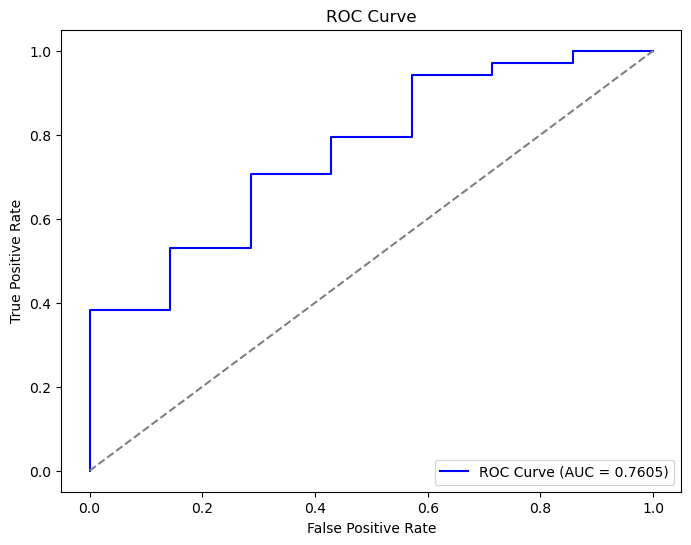

In [345]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Visual Observations**:

The curve is above the diagonal line (random classifier), indicating that the model's predictions are better than random guessing.

**Key Insights**:

The model performs relatively well, with an AUC of 0.7605, suggesting that the model has a good ability to distinguish between the two classes. 

###### Feature Importance Heatmap

The purpose of the plot is to visually represent the contribution of each feature in predicting the likelihood of a company having a female CEO, as indicated by the logistic regression model's coefficients.

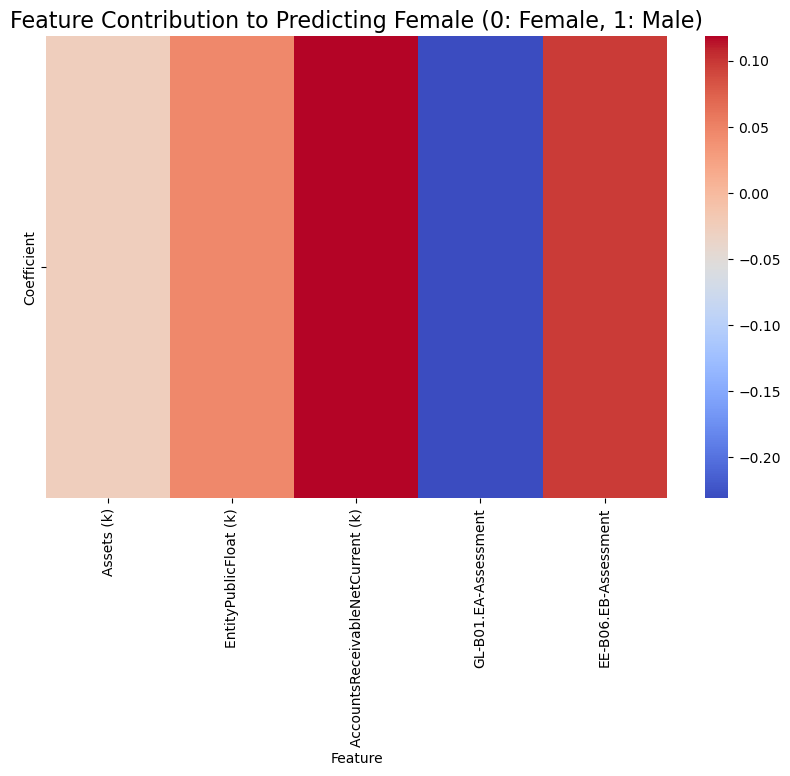

In [ ]:
# Get the coefficients from the Logistic Regression model (related to predicting class 1)
coefficients = model.coef_[0]  # model.coef_ has the shape (1, n_features)

# Create a DataFrame with the coefficients and corresponding feature names
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients  # Retain the signs of coefficients (not using abs)
})

# Create the figure and adjust the size
plt.figure(figsize=(10, 6))

# Plot a heatmap showing the negative coefficients related to female (class 0) or positive coefficients for male (class 1)
sns.heatmap(coef_df.set_index('Feature').T, annot=False, cmap="coolwarm", cbar=True)

# Add title and description
plt.title('Feature Contribution to Predicting Female (0: Female, 1: Male)', fontsize=16)

# Add colorbar label
cbar = plt.gca().collections[0].colorbar

# Display the plot
plt.show()

**Visual Observations**:

From the heatmap, we observe that several features, particularly "EntityPublicFloat (k)" and "GL-B01.EA-Assessment," have relatively higher positive coefficients, indicating they are associated with an increased likelihood of having a male CEO. On the other hand, features such as "EE-B06.EB-Assessment" and "Assets (k)" have negative coefficients, suggesting they are more favorable for a female CEO.

**Key Insights**:

Features like "Assets (k)" and "EE-B06.EB-Assessment" show negative coefficients, implying that larger company assets and positive gender-related assessments could be factors promoting a female CEO.

Features like "EntityPublicFloat (k)" and "GL-B01.EA-Assessment" have higher positive values, which might indicate that companies with higher public shareholding and better gender balance at the highest governance body tend to have male CEOs.

The results could reflect the increasing recognition of the importance of gender equality in leadership. Companies with more assets and progressive labor practices are likely to be at the forefront of social responsibility and diversity initiatives. Larger companies, with their broader resources and visibility, are more likely to appoint women to executive roles, including the position of CEO. Additionally, their commitment to fair labor practices and gender equality could also translate into selecting female leaders who align with their values of equity and inclusivity.

## Regression

### Gradient Boosting Regression

#### Feature Selection For Gradient Boosting Regression

Dependent Variable:

Total: Represents the overall gender equality score or assessment for a company.

Independent Variables (Features):

ComprehensiveIncomeNetOfTax (k): The comprehensive income of the company after tax, which can be used to assess its financial performance and profitability.

EntityPublicFloat (k): The public float of the company's shares post-IPO. It reflects the company's governance transparency and its ability to attract public investment.

GPG-C01.EA-Evidence_Sentiment: This feature captures whether the company collects sex-disaggregated pay data. The sentiment score derived from text analysis reflects the company's stance on gender pay gap data collection. A positive sentiment would suggest the company actively supports gender equality in pay, while a negative sentiment would suggest the opposite.

GR-B07.EA-Assessment: This feature indicates whether the company procures from women-owned businesses. Gender-responsive procurement is a critical area of corporate responsibility related to gender equality.

GL-B01.EA-Assessment: This feature assesses whether the company maintains gender balance (between 40-60%) at the highest governance body, which reflects the company's commitment to gender equality in leadership positions.

#### Model Selection

##### Model Rationale:

The Gradient Boosting Regressor (GBR) was selected for this task because it is highly effective in capturing non-linear relationships and interactions between features, making it well-suited for predicting the target variable (Total). Gradient Boosting combines multiple weak learners, usually decision trees, to create a strong predictive model. This ensemble approach minimizes errors iteratively by focusing on the weaknesses of previous iterations, thus improving overall accuracy. Additionally, it has a robust ability to handle a mix of numerical and categorical variables, such as financial metrics and sentiment scores, which are present in this dataset.

##### Overview of Algorithms:

Gradient Boosting Regressor works by optimizing a loss function through the iterative addition of decision trees as weak learners. The core algorithm minimizes the loss function L(y,f(x)), where yy is the true target and f(x) is the predicted value. The model uses gradient descent to adjust tree predictions, effectively minimizing errors over iterations.

The update rule for Gradient Boosting is as follows:

1 Initialize the model with a constant prediction:


$$ F_0(x) = \arg\min_{\theta} \sum_{i=1}^{N} L(y_i, \theta) $$ 


where $ ( F_0(x) ) $  is the initial prediction and $  ( L(y_i, \theta) ) $ is the loss function.

2  For $ ( m = 1, 2, \dots, M ) $ iterations:

1. Compute the gradient (pseudo-residuals):
   
  $$  r_{im} = - \left[ \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right]_{F(x) = F_{m-1}(x)} $$ 

   where $ ( r_{im} ) $ is the residual at the $ ( m ) $-th iteration, and $ ( F_{m-1}(x) ) $ is the model from the previous iteration.

2. Fit a weak learner $ ( h_m(x) ) $ to the residuals $ ( r_{im} )$.

3. Update the model:

   $$ F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x) $$ 

   where $ ( \eta ) $ is the learning rate, and $ ( h_m(x) ) $ is the weak learner fitted to the residuals.


#### Training and Testing Strategy For Gradient Boosting Regression

The dataset is divided into training (80%) and testing (20%) sets using train_test_split.

In [41]:
# Define features and target variable
X = df_br.drop(columns=['Total'])
y = df_br['Total']

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5000)

In [45]:
# Initialize the GradientBoostingRegressor model with default parameters
model = GradientBoostingRegressor(random_state=5000)

# Train the model with default parameters
model.fit(X_train, y_train)

# Make predictions with the default model
y_pred = model.predict(X_test)

#### Model Evaluation Metrics For Gradient Boosting Regression

We use Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) to measure the average and square-rooted differences between predicted and actual values.
And then use R-squared (R²) to assess how well the model explains the variance in the target variable.

In [47]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'R-squared: {r2:.4f}')

Mean Squared Error: 0.0135
Root Mean Squared Error: 0.1160
R-squared: 0.4435


Low MSE and RMSE values indicate good model performance, meaning the model's predictions are close to the actual values.
A higher R² value would be better, but 0.44 indicates the model is explaining about 44.35% of the variance in the data, which can be considered reasonable, though improvements may be possible.

#### Results  For Gradient Boosting Regression

##### Model Performance Summary:

The Gradient Boosting Regressor model was trained to predict the target variable, Total, which represents the gender equality score for the company. The model's performance was evaluated using three key metrics: Mean Squared Error (MSE) of 0.0135, indicating a relatively low average squared error between the predicted and actual values; Root Mean Squared Error (RMSE) of 0.1160, which provides a moderate error measurement for the predictions; and R-squared (R²) of 0.4435, suggesting that the model explains approximately 44.35% of the variance in the target variable. While not perfect, these results indicate that the model captures a significant portion of the variability in the data.

##### Visualizations:

###### Q-Q plot

The Q-Q plot (Quantile-Quantile plot) is used to assess whether the residuals from a regression model follow a normal distribution. In the plot, the blue dots represent the ordered residual values, and the red line is the theoretical quantile line for a normal distribution.

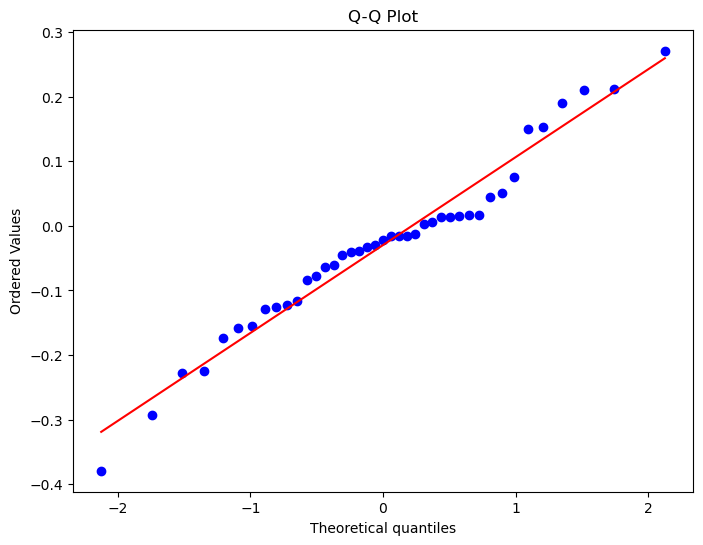

In [53]:
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

**Visual Observations**:

From the Q-Q plot, we can observe that the residuals are fairly aligned with the red line, especially around the middle portion. This alignment indicates that the residuals are approximately normally distributed, which is a good sign for the model, as normality of residuals is one of the assumptions for many regression models.

**Key Insights**:

However, there is some deviation at the ends of the plot, which could indicate slight skewness or the presence of outliers in the data. These deviations suggest that, while the model's residuals are generally normal, there may still be some room for improvement. Further investigation into the data or the model might be needed to address these issues, such as transforming variables or handling outliers more effectively.


###### Feature Importance Plot

The purpose of plotting the feature importance is to evaluate which features have the most influence on the model’s predictions. This helps us understand the relative importance of each feature and guides further analysis, such as selecting the most important features for future modeling or improving model performance.

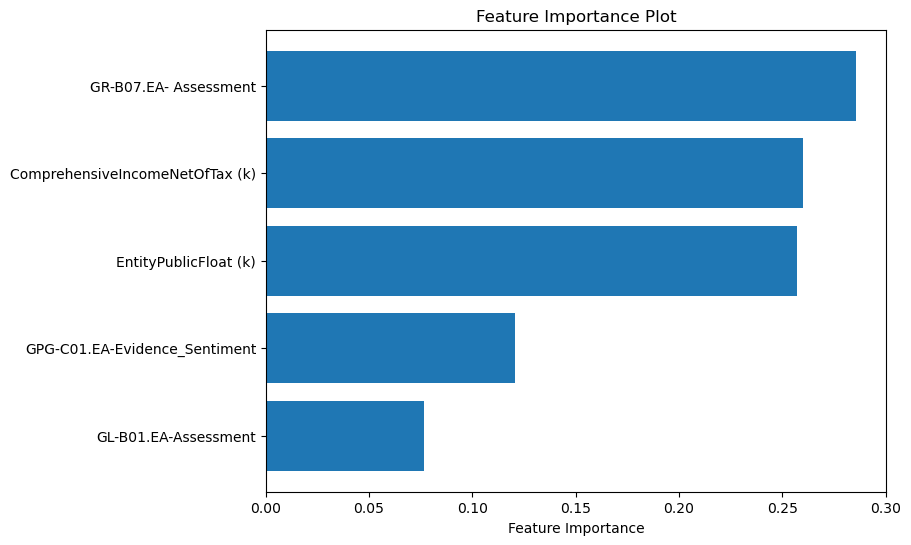

In [54]:
plt.figure(figsize=(8, 6))
feature_importances = model.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)

plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.show()

**Visual Observations**:

From the feature importance plot, we can see that "GR-B07.EA-Assessment" has the highest importance, followed by "ComprehensiveIncomeNetOfTax (k)" and "EntityPublicFloat (k)". Other features, such as "GPG-C01.EA-Evidence_Sentiment" and "GL-B01.EA-Assessment", show lower importance.

**Key Insights**:

The most important feature is "GR-B07.EA-Assessment," indicating that the company’s procurement from women-owned businesses is a strong predictor of the target variable, "Total". Financial features like "ComprehensiveIncomeNetOfTax (k)" and "EntityPublicFloat (k)" also play significant roles. However, features like "GPG-C01.EA-Evidence_Sentiment" and "GL-B01.EA-Assessment" have relatively lower importance, suggesting that their contribution to the model’s prediction is smaller.

## Multi-class classification

### Random Forest Classifier

#### Features Selection For Random Forest Classifier

**Features**:

Dependent Variable:

HSW-D01.EC-Assessment: This is the target variable representing the assessment of whether the company provides coverage for specific health-related services (e.g., maternal health, sexual and reproductive health, and mental health). The three possible labels are:

Met: The company provides coverage for more than two different services (full score).

Partially Met: The company provides coverage for only one service.

Unmet: The company does not provide coverage for any of these services.

Indeependent Variable:

HSW-D01.EC-Evidence: This feature contains the actual evidence related to the services the company provides. The evidence could be detailed text or categorical data indicating which services are covered. This is critical for understanding whether the company meets, partially meets, or does not meet the health coverage criteria. The presence of specific keywords or phrases in this evidence could be used to classify the company's assessment. We will use TFIDF to extract relevant features from text.

**Objective**:

The objective of this model is to automate the classification of companies into categories such as Met, Partially Met, or Unmet based on their health coverage for maternal health, sexual and reproductive health, and mental health services. Currently, such assessments are made manually by reviewing textual evidence, which is time-consuming and subjective. By applying supervised learning using the Random Forest classifier and extracting features from TF-IDF representations of the evidence text, we aim to create an automated, efficient, and objective classification system. This will help streamline the process, reduce bias, and scale the assessment of large datasets, enabling data-driven decisions regarding gender equity and health coverage practices.

#### Model Selection

##### Model Rationale:

The Random Forest Classifier is selected for this task due to its robustness and ability to handle both numerical and categorical data, making it well-suited for complex datasets with diverse features. The model works by constructing multiple decision trees during training and outputs the mode of the classes for classification tasks. This ensemble method helps reduce the risk of overfitting compared to a single decision tree, improving its generalizability and accuracy. Additionally, Random Forest provides feature importance scores, which help identify the most relevant features for classification, a key advantage when dealing with high-dimensional data, such as text or structured numerical data.

##### Overview of Algorithms:

The Random Forest Classifier is an ensemble learning method that builds a multitude of decision trees and merges their outputs to produce a more accurate and stable prediction. Each tree is trained on a random subset of the data, and only a random subset of features is considered when splitting nodes in each tree, which introduces diversity and improves the model's performance. 

#### Training and Testing Strategy For Random Forest Classifier

We split the data, 80% of the data is used for training, and the remaining 20% is reserved for testing.

In [ ]:
X = df_rf['HSW-D01.EC-Assessment']
y = df_rf['HSW-D01.EC-Assessment']

In [137]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5000)

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform the test data
X_test_tfidf = tfidf.transform(X_test)

# Initialize the Random Forest classifier
model = RandomForestClassifier(random_state=5000, class_weight='balanced')

# Train the model
model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = model.predict(X_test_tfidf)

#### Model Evaluation Metrics For Random Forest Classifier

We generated a confusion matrix and classification report to assess the model's performance across different classes.

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')  # Macro average for multiclass
recall = recall_score(y_test, y_pred, average='macro')  # Macro average for multiclass
f1_macro = f1_score(y_test, y_pred, average='macro')  # Macro average F1 score
f1_micro = f1_score(y_test, y_pred, average='micro')  # Micro average F1 score

# Confusion matrix for multiclass classification
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification report for detailed metrics per class
class_report = classification_report(y_test, y_pred)

# Print the evaluation results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision (Macro Average): {precision:.4f}')
print(f'Recall (Macro Average): {recall:.4f}')
print(f'Macro F1 Score: {f1_macro:.4f}')
print(f'Micro F1 Score: {f1_micro:.4f}')

# Print the classification report
print('Classification Report:')
print(class_report)

Accuracy: 0.6829
Precision (Macro Average): 0.3974
Recall (Macro Average): 0.4604
Macro F1 Score: 0.3985
Micro F1 Score: 0.6829
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.78      0.86        32
           1       0.00      0.00      0.00         4
           2       0.23      0.60      0.33         5

    accuracy                           0.68        41
   macro avg       0.40      0.46      0.40        41
weighted avg       0.78      0.68      0.71        41



#### Results For Random Forest Classifier

##### Model Performance Summary: 

The perfomance is as follows:

Accuracy: The model achieves an accuracy of 68.29%, which indicates it correctly classifies about 68% of the instances in the test set.

Precision (Macro Average): The macro average precision is 39.74%, meaning the model has moderate precision when considering all classes equally.

Recall (Macro Average): The macro average recall is 46.04%, which shows that the model's ability to identify all relevant instances across all classes is moderate.

F1 Score: The macro average F1 score is 39.85%, indicating a balance between precision and recall, but the overall performance could be improved.

Micro F1 Score: The micro average F1 score is 68.29%, which considers the total number of true positives, false positives, and false negatives across all classes and aligns with the accuracy.

##### Visualizations:

The purpose of generating this two plots is to visualize the importance of various features in predicting the target variable, which in this case is related to the company's coverage of health services. This helps to identify which factors are most influential in determining the classification of the company's health coverage status.

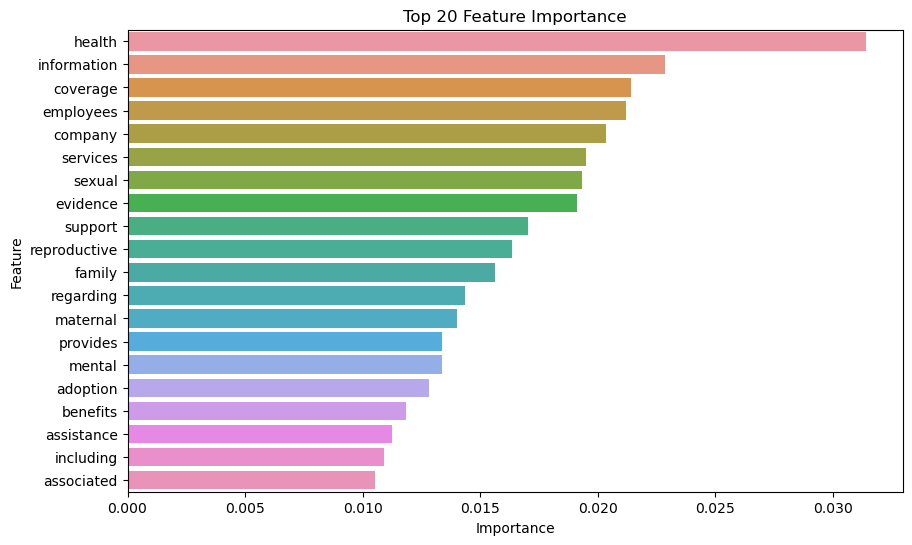

In [ ]:
# Get feature importances
feature_importances = model.feature_importances_

# Get feature names (for Tfidf, feature names are obtained through get_feature_names_out)
feature_names = tfidf.get_feature_names_out()

# Combine feature names and importance into a DataFrame
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df.head(20))  # Display the top 20 most important features
plt.title('Top 20 Feature Importance')
plt.show()

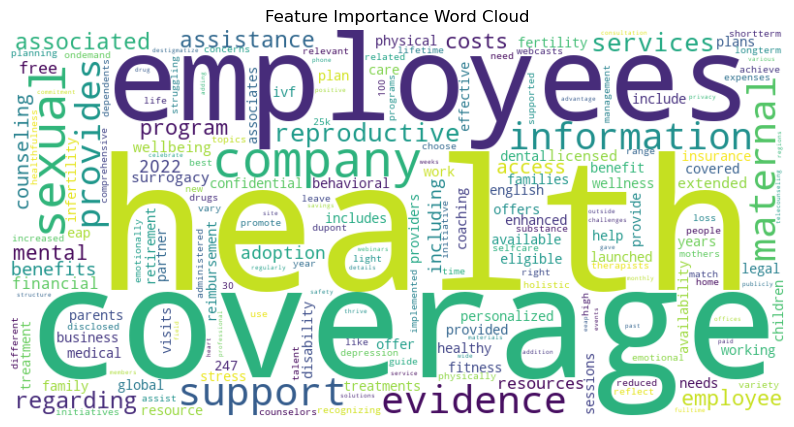

In [140]:
# Combine feature names and importance into a dictionary
feature_dict = dict(zip(feature_names, feature_importances))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(feature_dict)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for the word cloud
plt.title('Feature Importance Word Cloud')
plt.show()

**Visual Observations**:

The feature "health" has the highest importance, followed by "information," "coverage," and "employees." These features significantly influence the model's predictions, showing that health-related aspects are crucial for the classification.

**Key Insights**:

"Health" and "information" are dominant features, indicating that health services coverage and related data are strong predictors.

Features such as "evidence," "support," and "reproductive" also show notable importance, suggesting that the company's actions and support in health services, including reproductive health, contribute significantly to the classification.

The lower-ranked features, like "assistance" and "associated," still have some influence but are less significant in comparison to the top features.

# Discussion

## Result Interpretation:

As for SVM, the main research question is to understand how factors like a company's financial health and revenue affect its decision to buy from women-owned businesses, with the goal of seeing if financial strength influences their support for gender equality in business. From the feature importance plot, we see that the most important factor influencing a company's decision to buy from women-owned businesses is its gender equality score (Total). 

The results show that companies committed to gender equality are more likely to support women-owned businesses. Other key factors include the company’s financial health, such as comprehensive income, operating income, and revenue, which also play a significant role in this decision. 

In addition, the results suggest that companies with better financial health are more likely to support diversity initiatives like procurement from women-owned businesses. Therefore, improving financial stability could be a strategy for companies wanting to boost their gender equity practices. Policymakers may also use these insights to identify companies that align with gender equality goals and direct support or incentives towards them.

As for Logistic Regression, the primary research question is to understand how financial and governance-related factors (such as company assets, public float, current receivables, and gender-related governance practices) influence the likelihood of having a female CEO. We are particularly interested in determining which of these factors are most strongly associated with the gender of the CEO (male or female).

The results reveals that financial and governance factors play a crucial role in shaping the gender of a company's CEO. Specifically, companies with larger total assets and a stronger commitment to gender equality (such as support for gender-equitable policies and practices) tend to have female CEOs. On the other hand, companies with a higher level of public shareholding and a more balanced gender representation at the governance level are more likely to have male CEOs. These findings suggest that financial stability and alignment with gender equality principles could help increase the representation of women in leadership roles.

As for Gradient Boosting Regression, the main research question focuses on identifying the key factors that influence a company's overall gender equality score. Specifically, it seeks to understand how financial health (e.g., income and public float) and gender-related practices (e.g., procurement from women-owned businesses, gender balance in governance) contribute to a company's gender equality efforts.

The results reveals that several key factors influence a company's gender equality score. First, companies that procure from women-owned businesses tend to score higher in gender equality, indicating the importance of gender-responsive procurement practices. A company's financial health, particularly its comprehensive income, also plays a significant role, as companies with better financial performance are more likely to invest in gender equality initiatives. Additionally, companies with a larger public float may face more external pressure on gender equality, contributing to higher scores. Finally, companies that demonstrate a positive sentiment towards addressing the gender pay gap are also more likely to score higher in gender equality, showing that attitudes toward pay equity matter.

As for Random Forest Classifier, we focus on understanding how the evidence provided by companies regarding health coverage impacts the classification of their compliance with providing services related to maternal health, sexual and reproductive health, and mental health. Specifically, the goal is to predict whether a company meets, partially meets, or does not meet the health coverage criteria using the available evidence.

These findings have important implications for companies aiming to improve their health coverage offerings. By understanding which factors—such as "Health" and "Coverage"—are most influential, companies can better tailor their services to meet gender-equity and healthcare access standards. Policymakers and advocacy groups can use this information to assess and promote companies that are making significant strides in providing comprehensive health coverage services, ensuring that more businesses align with broader health and gender equality goals.

## Model Performance Comparison:

We compared the performance of four different models—SVM, Logistic Regression, Gradient Boosting Regression, and Random Forest, although the research questions we want to explore is quite different, but we use the same dataset.

SVM showed good results with an accuracy of 73%, precision of 79%, and a relatively balanced recall of 68%, meaning it was able to predict "positive" cases (i.e., correctly identify companies meeting the criteria) but slightly missed some "true positives."

Logistic Regression performed the best overall, with the highest accuracy of 83%, perfect recall (1.0), and a strong F1 score of 0.91, meaning it was very effective at identifying both positive and negative cases. The ROC-AUC score (0.76) indicates that the model was able to differentiate between categories reasonably well.

Gradient Boosting Regression is a regression model, so it measures errors in predicting continuous variables. The R-squared value of 0.44 indicates that the model explained about 44% of the variance in the target variable, with a low error (RMSE of 0.12), but it's not directly comparable to classification models like the others.

Random Forest showed decent accuracy (68%) but struggled with precision and recall for some categories, especially for the "1" category, where it performed poorly. The macro-average metrics suggest that it struggles with some of the less frequent classes, but the micro-average F1 score (0.68) indicates it’s reasonably good at overall classification.

In conclusion, Logistic Regression performed the best for this classification task, followed by SVM. The Random Forest model had some issues with class imbalance, and the Gradient Boosting Regression wasn't directly comparable since it’s a regression model, not a classification one.

## Insights Gained:

**Financial Health Drives Gender Equality Support:** Companies with stronger financial health (such as higher comprehensive income and revenue) are more likely to engage in gender-equal practices like procurement from women-owned businesses or promoting women to leadership positions.

**Gender Equality Influences Leadership Diversity:** Governance factors, including support for gender-equitable policies and the balance of genders at the highest levels, are strongly linked to the likelihood of having a female CEO.

**Importance of Gender-Responsive Procurement:** Procurement from women-owned businesses is a major factor in improving a company’s gender equality score, indicating that companies that actively support women-owned businesses tend to have more robust gender equity practices.

**Financial Performance and Gender Equity Go Hand in Hand:** Better financial performance enables companies to invest more in gender equity initiatives, including pay equity and gender balance at leadership levels.

**Model Training Insights:** From the model training, we learned that while financial and governance data is critical in determining gender equity outcomes, certain features (e.g., gender equality score, procurement from women-owned businesses) play a particularly pivotal role. We also saw that ensemble methods like Random Forest are well-suited for handling complex, multi-dimensional data but may struggle with class imbalances.